<a href="https://colab.research.google.com/github/Supavee/Dog-Detector/blob/main/Dog_Detector_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai import *
from fastai.vision import *
from torchvision.models import * 

import os
import matplotlib.pyplot as plt

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [3]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.10)


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"supavee","key":"9e436da50a07cf41d236a26ed4ebc88d"}'}

In [5]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d supavee/dogdog

 98% 178M/182M [00:01<00:00, 123MB/s]
100% 182M/182M [00:01<00:00, 137MB/s]


In [8]:
!pip install zip_files

In [9]:
from zipfile import ZipFile
file_name="dogdog.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [10]:
path = Path("/content/Dogs")
path

PosixPath('/content/Dogs')

In [11]:
path.ls()

[PosixPath('/content/Dogs/test'),
 PosixPath('/content/Dogs/valid'),
 PosixPath('/content/Dogs/train')]

In [12]:
path_img = path/'train/'

# path_anno
path_img

PosixPath('/content/Dogs/train')

In [13]:
path_img.ls()

[PosixPath('/content/Dogs/train/05KaoJao'),
 PosixPath('/content/Dogs/train/02Dougie'),
 PosixPath('/content/Dogs/train/01Other'),
 PosixPath('/content/Dogs/train/12Topi'),
 PosixPath('/content/Dogs/train/07Luke'),
 PosixPath('/content/Dogs/train/04Hana'),
 PosixPath('/content/Dogs/train/06Kiara'),
 PosixPath('/content/Dogs/train/10Maya'),
 PosixPath('/content/Dogs/train/08Manny'),
 PosixPath('/content/Dogs/train/11Ninja'),
 PosixPath('/content/Dogs/train/09Maple'),
 PosixPath('/content/Dogs/train/03Finn')]

In [14]:
tfms = get_transforms()
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=227, num_workers=0).normalize(imagenet_stats)

In [15]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=227, num_workers=0, classes=data.classes[:20]).normalize(imagenet_stats)

In [16]:
#data.normalize(imagenet_stats)

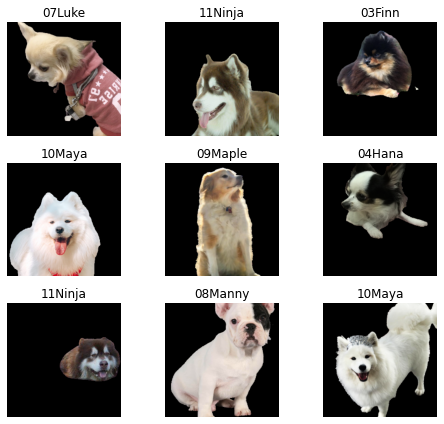

In [17]:
data.show_batch(rows = 3 ,figsize = (7,6))

In [18]:
print(data.classes)
len(data.classes), data.c # data.c = for classification problems its number of classes

['01Other', '02Dougie', '03Finn', '04Hana', '05KaoJao', '06Kiara', '07Luke', '08Manny', '09Maple', '10Maya', '11Ninja', '12Topi']


(12, 12)

**Train ResNet34 Model**


In [19]:
learn = create_cnn(data , models.resnet34, metrics = accuracy) 

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,2.217172,0.085263,0.986301,05:39
1,1.071704,0.036366,0.995434,05:38
2,0.655261,0.039890,0.990868,05:36
3,0.446360,0.038193,0.995434,05:37


In [21]:
learn.model_dir = "/content/"
learn.save('stage-1')

In [22]:
learn.unfreeze()

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


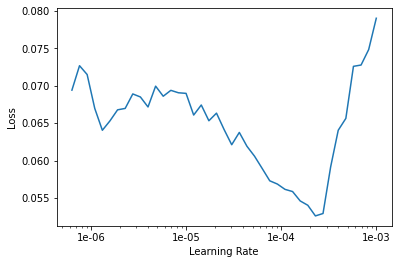

In [24]:
learn.recorder.plot()

In [25]:
learn.metrics=[accuracy,
               Precision(),
               Recall()]

In [26]:
learn.fit_one_cycle(4, max_lr=slice(3e-6,3e-5))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.065027,0.034393,0.995434,0.995833,0.995833,08:04
1,0.060522,0.031899,0.995434,0.995833,0.995833,08:03
2,0.058858,0.034397,0.990868,0.992500,0.992045,08:02
3,0.048865,0.030554,0.990868,0.992500,0.992045,08:03


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [27]:
learn.model_dir = "/content/"
learn.save('stage-2')

In [28]:
learn.load('stage-2');

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

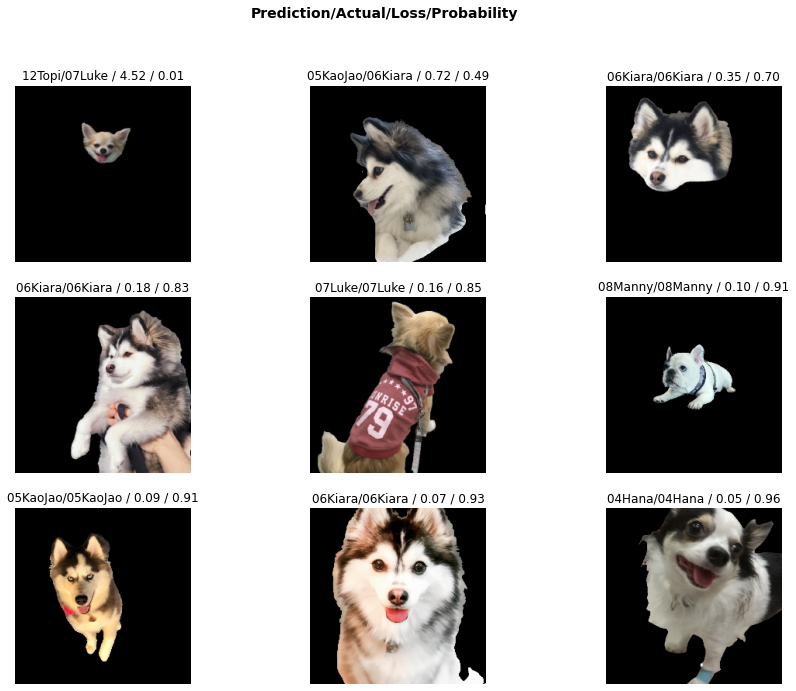

In [30]:
interp.plot_top_losses(9 , figsize = (15,11))

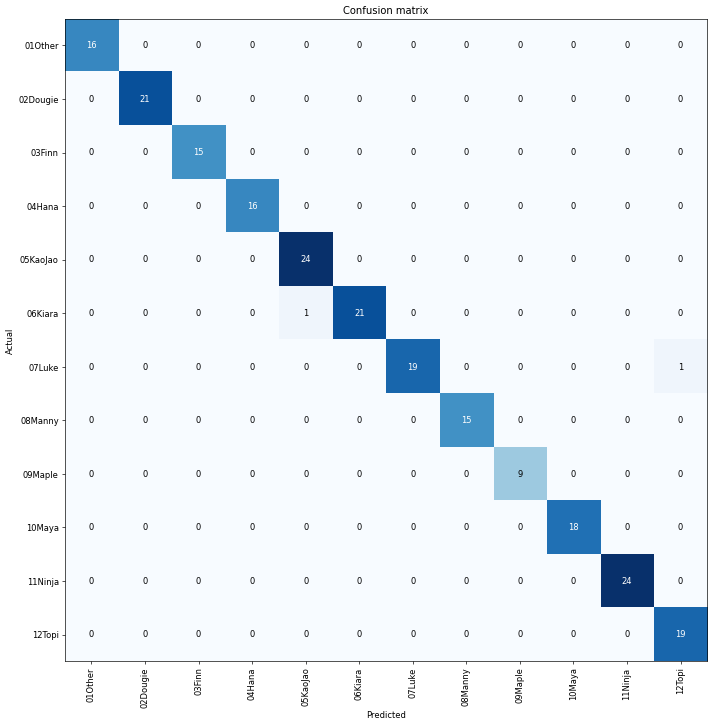

In [31]:
interp.plot_confusion_matrix(figsize = (12,12), dpi = 60)

In [32]:
interp.most_confused(min_val=1) # useful tool

[('06Kiara', '05KaoJao', 1), ('07Luke', '12Topi', 1)]

In [33]:
data.classes

['01Other',
 '02Dougie',
 '03Finn',
 '04Hana',
 '05KaoJao',
 '06Kiara',
 '07Luke',
 '08Manny',
 '09Maple',
 '10Maya',
 '11Ninja',
 '12Topi']

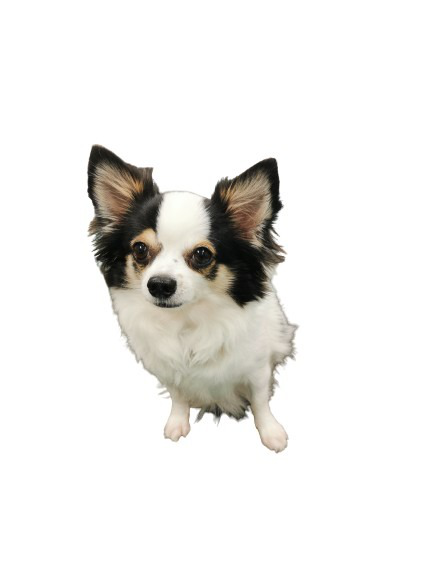

In [34]:
img = open_image('/content/Dogs/test/04Hana/IMG_20200118_162355.jpg')
img

In [35]:
classes = data.classes
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2 , models.resnet34)
learn.load('/content/stage-2')

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/Dogs;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/Dogs;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (

In [36]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class
pred_idx
outputs

tensor([6.5968e-08, 8.6053e-10, 3.3438e-09, 1.0000e+00, 1.0771e-12, 1.2361e-06,
        4.8283e-07, 7.2015e-09, 7.6069e-10, 9.7472e-09, 1.1604e-10, 6.7970e-09])

In [37]:
data.classes

['01Other',
 '02Dougie',
 '03Finn',
 '04Hana',
 '05KaoJao',
 '06Kiara',
 '07Luke',
 '08Manny',
 '09Maple',
 '10Maya',
 '11Ninja',
 '12Topi']

In [38]:
prediction = str(pred_class)
prediction[10:]
print("The predicted breed is " + prediction[:10] + '.')

The predicted breed is 04Hana.
